In [1]:
pip install -U jax

In [2]:
import jax
import jax.numpy as jnp

from jax import random
import jax.lax as lax
import cupy as cp
import pandas as pd

import numpy as np

import platform
import cpuinfo

import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.3 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [3]:


print("CPU:", platform.processor())
print("CPU info:", cpuinfo.get_cpu_info()['brand_raw'])


CPU: x86_64
CPU info: Intel(R) Xeon(R) CPU @ 2.20GHz


In [4]:

def gelu_np(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))


def lnorm_np(x, eps=1e-5):
    mean = np.mean(x, axis=0, keepdims=True)
    var = np.var(x, axis=0, keepdims=True)
    return (x - mean) / np.sqrt(var + eps)



def softmax_np(x, axis=-1):

    x_max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)


def matmul_np(a, b):
    return a @ b


def attention_per_head_np(K, Q, V, l_total, ddh, b, h):
    lb = l_total * b
    d = K.shape[0]
    E2 = np.zeros((d, lb), dtype=np.float32)

    for j in range(b):
        for i in range(h):
            indJ = j * l_total
            indI2 = i * ddh

            K_slice = K[indI2:indI2+ddh, indJ:indJ+l_total]
            Q_slice = Q[indI2:indI2+ddh, indJ:indJ+l_total]
            V_slice = V[indI2:indI2+ddh, indJ:indJ+l_total]

            scores = K_slice.T @ Q_slice / np.sqrt(ddh)
            E1 = softmax_np(scores, axis=0)

            result = V_slice @ E1
            E2[indI2:indI2+ddh, indJ:indJ+l_total] = result

    return E2


def mha_output_np(WO, E2, EI):
    AO = WO @ E2 + EI
    AO = lnorm_np(AO)
    return AO

def ffn_forward_np(W1, W2, AO):
    E3b = W1 @ AO
    E3 = gelu_np(E3b)
    EOb = W2 @ E3
    EO = lnorm_np(EOb + AO)
    return EO


In [5]:

def matmul_jax(a, b):
    result = a @ b
    return result

def attention_per_head_jax(K, Q, V, l, ddh, b, h):
    lb = l*b
    E2 = jnp.zeros((K.shape[0], lb), dtype=jnp.float32)

    def softmax(x, axis=-1):
        x_max = jnp.max(x, axis=axis, keepdims=True)
        e_x = jnp.exp(x - x_max)
        return e_x / jnp.sum(e_x, axis=axis, keepdims=True)

    def process_single_head(E2, idx):
        j, i = idx // h, idx % h
        indJ = j*l
        indI2 = i*ddh

        K_slice = lax.dynamic_slice(K, (indI2, indJ), (ddh, l)).astype(jnp.float32)
        Q_slice = lax.dynamic_slice(Q, (indI2, indJ), (ddh, l)).astype(jnp.float32)
        E1 = K_slice.T @ Q_slice
        E1 = E1 / jnp.sqrt(ddh)
        E1_normalized = softmax(E1, axis=0)
        V_slice = lax.dynamic_slice(V, (indI2, indJ), (ddh, l)).astype(jnp.float32)
        result = V_slice @ E1_normalized

        E2 = lax.dynamic_update_slice(E2, result, (indI2, indJ))
        return E2, None

    E2_init = jnp.zeros((d, lb), dtype=jnp.float32)
    idxs = jnp.arange(b * h)
    E2, _ = lax.scan(process_single_head, E2_init, idxs)

    return E2

def lnorm_jax(x, eps=1e-5):
    mean = jnp.mean(x, axis=0, keepdims=True)
    var = jnp.var(x, axis=0, keepdims=True)
    return (x - mean) / jnp.sqrt(var + eps)


def mha_output_jax(WO, E2, EI):
    AO = EI + WO @ E2
    AO= lnorm_jax(AO)
    return AO

def gelu_jax(x):
    return 0.5 * x * (1 + jnp.tanh(jnp.sqrt(2 / jnp.pi) * (x + 0.044715 * x**3)))


def ffn_forward_jax(W1, W2, AO):
    E3b = W1 @ AO
    E3 = gelu_jax(E3b)
    EOb = W2 @ E3
    EO = lnorm_jax(EOb + AO)
    return EO


b = 24
l = 128
d = 1024
h = 16


f = 4 * d
ddh = d // h
lb = b * l



In [6]:

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 7)

EI = (jax.random.uniform(keys[0], (d, lb), dtype=jnp.float32) )
WQ = (jax.random.uniform(keys[1], (d, d), dtype=jnp.float32) )
WK = (jax.random.uniform(keys[2], (d, d), dtype=jnp.float32) )
WV = (jax.random.uniform(keys[3], (d, d), dtype=jnp.float32) )
WO = (jax.random.uniform(keys[4], (d, d), dtype=jnp.float32) )
W1 = (jax.random.uniform(keys[5], (f, d), dtype=jnp.float32) )
W2 = (jax.random.uniform(keys[6], (d, f), dtype=jnp.float32) )

EI_np, WQ_np, WK_np, WV_np, WO_np, W1_np, W2_np = map(np.array, [EI, WQ, WK, WV, WO, W1, W2])


In [7]:
# NumPy
import time

results={}
results["NumPy"] = {}
Qc = matmul_np(WQ_np, EI_np)

start = time.time()
Qc = matmul_np(WQ_np, EI_np)

end = time.time()
results["NumPy"]["matmul_Q"] = end - start

start = time.time()
Kc = matmul_np(WK_np, EI_np)

end = time.time()
results["NumPy"]["matmul_K"] = end - start

start = time.time()
Vc = matmul_np(WV_np, EI_np)

end = time.time()
results["NumPy"]["matmul_V"] = end - start

start = time.time()
E2n = attention_per_head_np(Kc, Qc, Vc, l, ddh, b, h)

end = time.time()
results["NumPy"]["attention"] = end - start

start = time.time()
AOc = mha_output_np(WO_np, E2n, EI_np)

end = time.time()
results["NumPy"]["mha_output"] = end - start

start = time.time()
EOc = ffn_forward_np(W1_np, W2_np, AOc)

end = time.time()
results["NumPy"]["ffn"] = end - start

results["NumPy"]["total"] = sum(results["NumPy"].values())

In [8]:
print(results["NumPy"])

{'matmul_Q': 0.3700251579284668, 'matmul_K': 0.28078198432922363, 'matmul_V': 0.3179042339324951, 'attention': 2.6154532432556152, 'mha_output': 0.24192094802856445, 'ffn': 4.261523246765137, 'total': 8.087608814239502}


In [9]:

# JAX without JIT
results["JAX"] = {}


Qj = matmul_jax(WQ,  EI).block_until_ready()
start = time.time()
Qj = matmul_jax(WQ,  EI).block_until_ready()
end = time.time()
results["JAX"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jax(WK,  EI).block_until_ready()
end = time.time()
results["JAX"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jax(WV,  EI).block_until_ready()
end = time.time()
results["JAX"]["matmul_V"] = end - start

start = time.time()
E2j = attention_per_head_jax(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end = time.time()
results["JAX"]["attention"] = end - start

start = time.time()
AOj = mha_output_jax(WO, E2j, EI).block_until_ready()
end = time.time()
results["JAX"]["mha_output"] = end - start

start = time.time()
EOj = ffn_forward_jax(W1, W2, AOj).block_until_ready()
end = time.time()
results["JAX"]["ffn"] = end - start

results["JAX"]["total"] = sum(results["JAX"].values())

print(results["JAX"])


{'matmul_Q': 0.22125744819641113, 'matmul_K': 0.2402055263519287, 'matmul_V': 0.12958574295043945, 'attention': 0.9672906398773193, 'mha_output': 0.7910408973693848, 'ffn': 1.755138635635376, 'total': 4.104518890380859}


In [10]:
results["JIT-COMP"] = {}

# JIT

matmul_jit= jax.jit(matmul_jax)
attention_per_head_jit = jax.jit(attention_per_head_jax, static_argnums=(3, 4, 5, 6))
mha_output_jit = jax.jit(mha_output_jax)
ffn_forward_jit = jax.jit(ffn_forward_jax)



start = time.time()
Qj = matmul_jit(WQ,  EI).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jit(WK,  EI).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_K"] = end - start

start = time.time()

Vj = matmul_jit(WV,  EI).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_V"] = end - start



start_attention=  time.time()
E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JIT-COMP"]["attention"] = t

start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JIT-COMP"]["mha_output"] = t

start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn
results["JIT-COMP"]["ffn"] = t

results["JIT-COMP"]["total"] = sum(results["JIT-COMP"].values())



In [11]:
print(results["JIT-COMP"])

{'matmul_Q': 0.1594066619873047, 'matmul_K': 0.15569734573364258, 'matmul_V': 0.2825634479522705, 'attention': 0.7133440971374512, 'mha_output': 0.79115891456604, 'ffn': 1.6666619777679443, 'total': 3.7688324451446533}


In [12]:
# JAX with JIT
results["JAX-JIT"] = {}
Qj = matmul_jit(WQ,  EI).block_until_ready()
start = time.time()
Qj = matmul_jit(WQ,  EI).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jit(WK,  EI).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jit(WV,  EI).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_V"] = end - start


start_attention=  time.time()
E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JAX-JIT"]["attention"] = t


start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JAX-JIT"]["mha_output"] = t

start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn
results["JAX-JIT"]["ffn"] = t

results["JAX-JIT"]["total"] = sum(results["JAX-JIT"].values())

In [13]:
print(results["JAX-JIT"])

{'matmul_Q': 0.10063505172729492, 'matmul_K': 0.10168647766113281, 'matmul_V': 0.10551881790161133, 'attention': 0.05900406837463379, 'mha_output': 0.11359667778015137, 'ffn': 0.853933572769165, 'total': 1.3343746662139893}


In [14]:
print(results.keys())


dict_keys(['NumPy', 'JAX', 'JIT-COMP', 'JAX-JIT'])


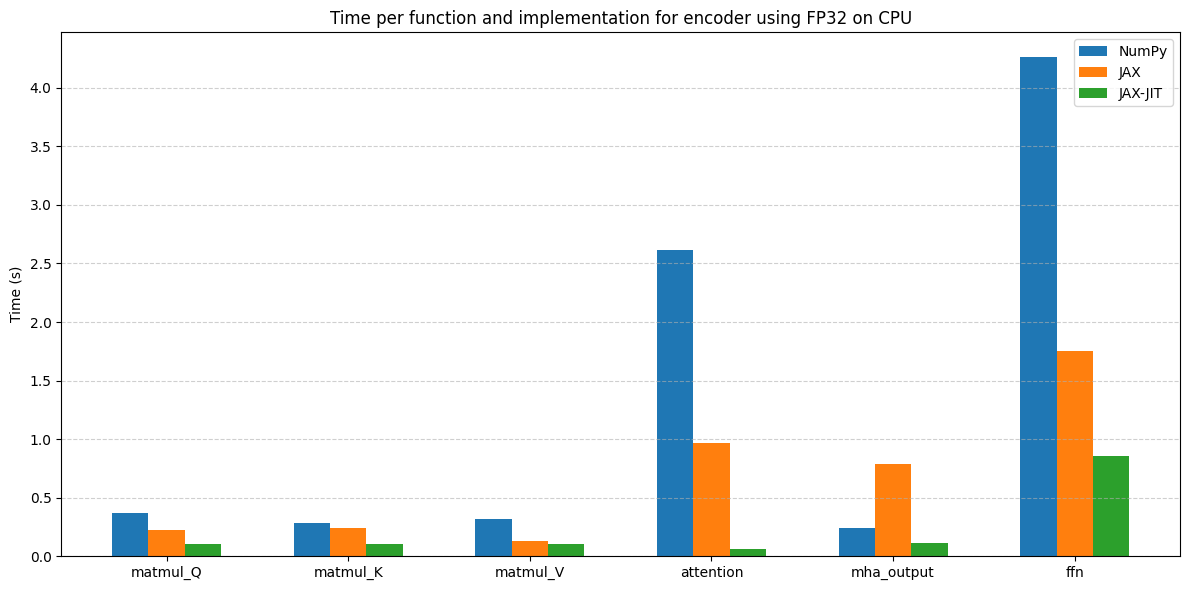

In [15]:

labels = ["matmul_Q","matmul_K","matmul_V", "attention", "mha_output", "ffn"]
x = np.arange(len(labels))
width = 0.20

fig, ax = plt.subplots(figsize=(12, 6))


ax.bar(x - 1*width, [results["NumPy"][l] for l in labels], width, label='NumPy')
ax.bar(x - 0*width, [results["JAX"][l] for l in labels], width, label='JAX')
#ax.bar(x + 0.5*width, [results["JIT-COMP"][l] for l in labels], width, label='JIT-COMP')
ax.bar(x + 1*width, [results["JAX-JIT"][l] for l in labels], width, label='JAX-JIT')

ax.set_ylabel('Time (s)')
ax.set_title('Time per function and implementation for encoder using FP32 on CPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

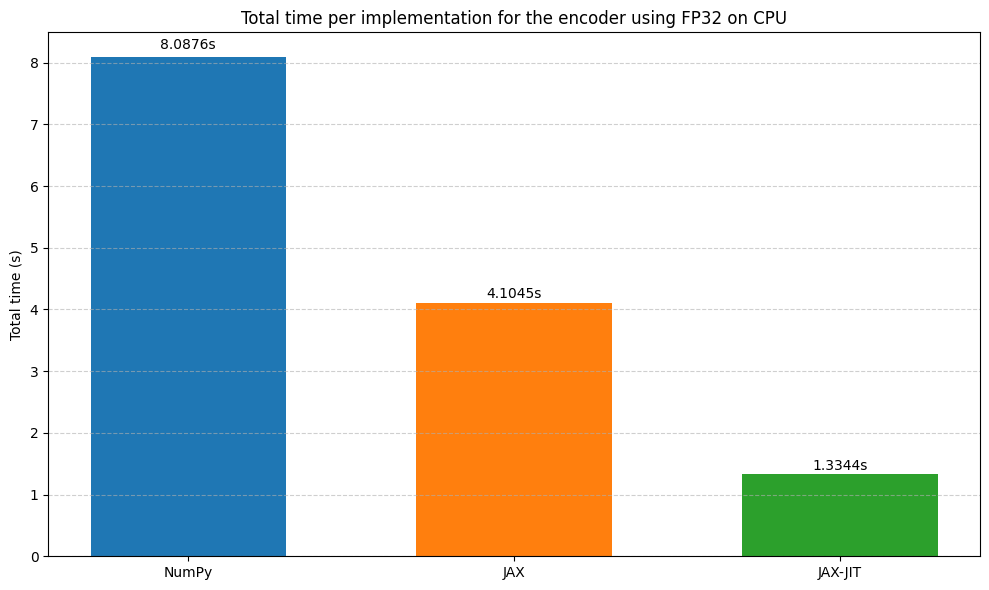

In [17]:



labels = ["NumPy", "JAX","JAX-JIT"]
x = np.arange(len(labels))
width = 0.6

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x, [results[label]["total"] for label in labels], width,
       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])


for i, label in enumerate(labels):
    height = results[label]["total"]
    ax.text(i, height + 0.01 * height, f'{height:.4f}s',
            ha='center', va='bottom')

ax.set_ylabel('Total time (s)')
ax.set_title('Total time per implementation for the encoder using FP32 on CPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()


plt.show()

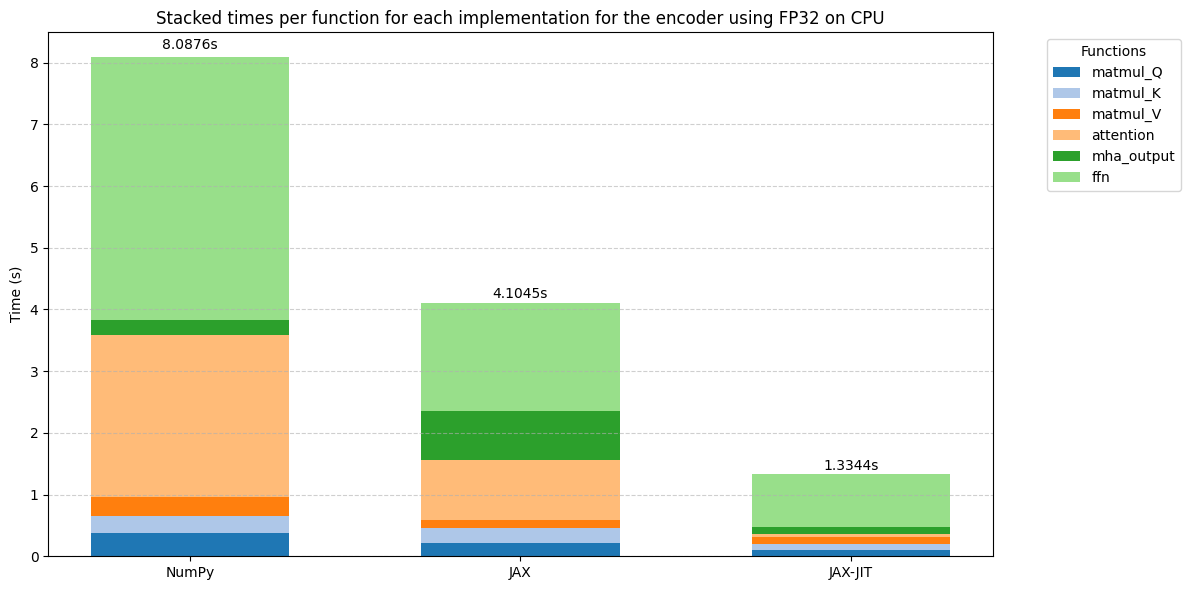

In [18]:

implementations = ["NumPy", "JAX", "JAX-JIT"]
functions = ["matmul_Q", "matmul_K", "matmul_V", "attention", "mha_output", "ffn"]
colors = plt.get_cmap("tab20").colors

x = np.arange(len(implementations))
width = 0.6

fig, ax = plt.subplots(figsize=(12, 6))


bottom = np.zeros(len(implementations))


for i, func in enumerate(functions):
    values = [results[impl][func] for impl in implementations]
    ax.bar(x, values, width, label=func, bottom=bottom, color=colors[i])
    bottom += values


for i, impl in enumerate(implementations):
    total = sum(results[impl][func] for func in functions)
    ax.text(i, total + 0.01 * total, f'{total:.4f}s', ha='center', va='bottom')

ax.set_ylabel('Time (s)')
ax.set_title('Stacked times per function for each implementation for the encoder using FP32 on CPU')
ax.set_xticks(x)
ax.set_xticklabels(implementations)

ax.legend(title="Functions", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


In [19]:
df = pd.DataFrame(results).T

In [20]:
cols_orden = ["matmul_Q", "matmul_K", "matmul_V", "attention", "mha_output", "ffn", "total"]
df = df[cols_orden]

In [21]:


display(df.style.format("{:.4f}"))





,matmul_Q,matmul_K,matmul_V,attention,mha_output,ffn,total
NumPy,0.3700,0.2808,0.3179,2.6155,0.2419,4.2615,8.0876
JAX,0.2213,0.2402,0.1296,0.9673,0.7910,1.7551,4.1045
JIT-COMP,0.1594,0.1557,0.2826,0.7133,0.7912,1.6667,3.7688
JAX-JIT,0.1006,0.1017,0.1055,0.0590,0.1136,0.8539,1.3344
